# 1. Imports

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import tables

# 2. Function Definitions

In [6]:

def get_topics(components, features, top_n=10):
    """
    Returns a list containing the top_n specified terms from each topic (component)
    :param components: the matrix containing the weights for each topic
    :param features: the terms 
    :param top_n: number of terms to take from each topic
    :return: a list of len(components) with each item a list of len(top_n) of the top words
    """
    topic_word_list = []  # Store the list of topics
    for i, comp in enumerate(components):  # Iterate over topics
        terms_comp = zip(features, comp)  # Pair features with weights
        sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:top_n]  # Get top words by weight
        topic_words = [t[0] for t in sorted_terms]  # Extract words only
        topic_word_list.append(topic_words)  # Append to list
        # print(f"Topic {i}: {' '.join(topic_words)}")  # Print the topic words as a string
    return topic_word_list


def compute_sparsity(matrix):
    """
    Calculates the sparsiity of the given array (used for NMF, no use for SVD matrices are full)
    """
    total_elements = matrix.size
    zero_elements = np.sum(matrix == 0)
    return zero_elements / total_elements

def save_to_hdf5(array, hdf5_file):
    with tables.open_file(hdf5_file, mode="w") as f:
            # Save array
            atom = tables.Float32Atom()
            array_shape = array.shape
            array_storage = f.create_carray(f.root, 'array', atom, array_shape)
            array_storage[:] = array


# Example: Store U, Sigma, and Vt into an HDF5 file
def save_svd_to_hdf5(U, Sigma, Vt, hdf5_file):
    with tables.open_file(hdf5_file, mode="w") as f:
        # Save U
        atom = tables.Float32Atom()
        u_shape = U.shape
        u_storage = f.create_carray(f.root, 'U', atom, u_shape)
        u_storage[:] = U

        # Save Sigma (as diagonal matrix for simplicity)
        sigma_storage = f.create_array(f.root, 'Sigma', Sigma)

        # Save Vt
        v_shape = Vt.shape
        v_storage = f.create_carray(f.root, 'Vt', atom, v_shape)
        v_storage[:] = Vt

# Example: Incrementally reconstruct and save the matrix
def incremental_reconstruction(hdf5_file, output_file, chunk_size=100):
    with tables.open_file(hdf5_file, mode="r") as f, \
         tables.open_file(output_file, mode="w") as out:
        
        U = f.root.U
        Sigma = f.root.Sigma
        Vt = f.root.Vt
        # Prepare the output file
        rows, cols = U.shape[0], Vt.shape[1]
        atom = tables.Float32Atom()
        recon_storage = out.create_carray(out.root, 'Reconstructed', atom, (rows, cols))
        
        # Iterate in chunks
        for start in range(0, rows, chunk_size):
            end = min(start + chunk_size, rows)
            # Load a chunk of U
            U_chunk = U[start:end, :]
            Vt_chunk = Vt[:, start:end]
            # Compute partial reconstruction for the chunk
            partial_chunk = U_chunk @ Sigma @ Vt
            
            # Write the result back incrementally
            recon_storage[start:end, :] = partial_chunk

            # print(f"Processed rows {start} to {end}")

        return recon_storage


def calculate_self_error(dtm, chunk_size=100):
    original_matrix = dtm  # Assuming the original matrix is stored under "Original"
    
    rows, cols = original_matrix.shape
    squared_error = 0.0
    
    # Iterate over chunks
    for start in range(0, rows, chunk_size):
        end = min(start + chunk_size, rows)
        # Read chunks of the original and reconstructed matrices
        orig_chunk = original_matrix[start:end, :].toarray()
        squared_error += np.sum((orig_chunk) ** 2)
    
    # Compute the total reconstruction error (Frobenius norm)
    frobenius_norm = np.sqrt(squared_error)
    return frobenius_norm

def calculate_reconstruction_error(dtm, original_hdf5, reconstructed_hdf5, chunk_size=100):
    with tables.open_file(original_hdf5, mode="r") as orig_file, \
         tables.open_file(reconstructed_hdf5, mode="r") as recon_file:
        
        original_matrix = dtm  # Assuming the original matrix is stored under "Original"
        reconstructed_matrix = recon_file.root.Reconstructed  # Assuming the reconstructed matrix is stored under "Reconstructed"
        
        rows, cols = original_matrix.shape
        squared_error = 0.0
        
        # Iterate over chunks
        for start in range(0, rows, chunk_size):
            end = min(start + chunk_size, rows)
            
            # Read chunks of the original and reconstructed matrices
            orig_chunk = original_matrix[start:end, :].toarray()
            recon_chunk = reconstructed_matrix[start:end, :]
            # Compute the squared difference for this chunk
            squared_error += np.sum((orig_chunk - recon_chunk) ** 2)
        
        # Compute the total reconstruction error (Frobenius norm)
        frobenius_norm = np.sqrt(squared_error)
        return frobenius_norm


def compute_reconstruction_error(dtm, U_k, Sigma_k, V_k):
    # Paths for HDF5 storage
    hdf5_file = "svd_decomposition.h5"
    reconstructed_file = "reconstructed_matrix.h5"
    original_hdf5 = "original_matrix.h5"  # Path to the file containing the original matrix

    # save_to_hdf5(dtm, original_hdf5)
    save_svd_to_hdf5(U=U_k,Sigma=Sigma_k,Vt=V_k,hdf5_file=hdf5_file)
    incremental_reconstruction(hdf5_file=hdf5_file,output_file=reconstructed_file,chunk_size=1000)
    error = calculate_reconstruction_error(dtm, original_hdf5, reconstructed_file, chunk_size=1000)
    print(f"Reconstruction Error (Frobenius norm) for n_components={Sigma_k[0].size}: {error}")





def run_svd_none(dtm, vectorizer,n_components = 3, show_word_clouds = True):

    for i in range(2,n_components):
        svd_model = TruncatedSVD(n_components = i, random_state = 2024)
        U_k = svd_model.fit_transform((dtm))
        V_k = svd_model.components_
        Sigma_k = np.diag(svd_model.singular_values_)  # Diagonal matrix of singular values
        features = vectorizer.get_feature_names_out()
        compute_reconstruction_error(dtm=dtm,U_k=U_k,Sigma_k=Sigma_k,V_k=V_k)

    if show_word_clouds:
        topics = get_topics(V_k, features, top_n = 10)
        create_word_clouds(components=V_k, features=features)




def create_word_clouds(components, features):
    try:
        # Define the number of topics
        num_topics = len(components)
        print(num_topics)
        # Calculate the number of rows and columns for the subplots
        cols = 4  # Number of columns (adjust as needed)
        rows = (num_topics + cols - 1) // cols  # Calculate rows needed to fit all subplots

        # Create a larger figure with subplots
        fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 2))  # Adjust figure size

        # Flatten the axes array for easier iteration
        axes = axes.flatten()

        for i in range(num_topics):
            # Generate a word cloud for the topic
            wordcloud = WordCloud(width=600, height=400).generate_from_frequencies(
                dict(zip(features, components[i]))
            )

            # Plot the word cloud in the corresponding subplot
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].axis('off')  # Turn off axis
            axes[i].set_title(f"Topic {i+1}")  # Set title for each subplot

        # Turn off any unused subplots
        for j in range(num_topics, len(axes)):
            axes[j].axis('off')

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the combined figure
        plt.show()
    except Exception:
        print(Exception)

# 3. Data Initialization

In [7]:
# Load dataset
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
documents = data.data

# Vectorize
vectorizer = TfidfVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(documents)

error = calculate_self_error(dtm, chunk_size=1000)
print(f"Original Error (Frobenius norm): {error}")

Original Error (Frobenius norm): 137.12038506363663


Reconstruction Error (Frobenius norm) for n_components=2: 252.23050691342652
2


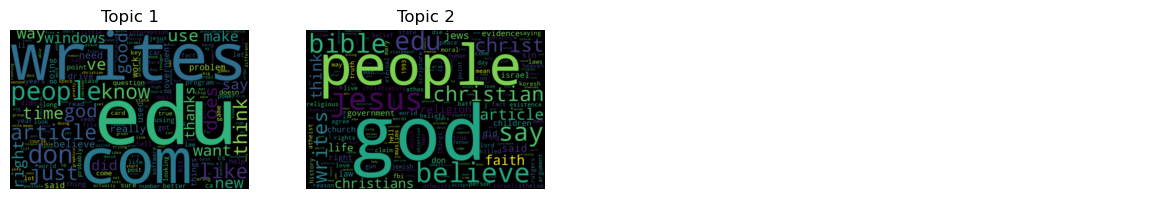

In [10]:
run_svd_none(dtm=dtm, vectorizer=vectorizer, n_components=3, show_word_clouds=True)

In [9]:
NMF_model = NMF(n_components=2, random_state=2025)
W = NMF_model.fit_transform(dtm)
H = NMF_model.components_
print(f"Reconstruction Error NMF for n_components={2}: {NMF_model.reconstruction_err_/error*100}%")

Reconstruction Error NMF for n_components=2: 99.23776814345523%
